In [6]:
from hyperband.hyperband import Hyperband
from hyperopt import hp
from xgboost import XGBRegressor as XGB
from hyperopt.pyll.stochastic import sample
import datetime
import pandas as pd
import numpy as np
from pprint import pprint
import json
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
import GPy
import GPyOpt
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from functools import reduce

In [44]:
def load_data():
    dframe_path = 'data/cabauw/processed-full-log.csv.gz'
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

    df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
    df = df[df.ds != 201603]
    
    return df

df = load_data()
wind_temp_levels = df.pivot_table(
    values=['wind', 'temp'], columns='z', index=['ds', 'tt']
).reset_index()
wind_temp_levels.columns = [
    '%s_%d' % (a, b) if b else a
    for a, b in wind_temp_levels.columns.values
]

ddf = df.merge(wind_temp_levels, on=['ds', 'tt']).dropna()
ddf = ddf[(ddf.zL > -2) & (ddf.zL < 1)]


feats = [
    'air_dens', 'wind', 'temp', 'virtual_temp',
    'soil_temp', 'z',
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux',
    'soilheat', 'netrad', 'temp_10', 'temp_20', 'temp_40', 'wind_10',
    'wind_20', 'wind_40'
]

ddf = ddf[feats + ['phi_m', 'ds']].dropna()

In [45]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(19)
reduct = svd.fit_transform(ddf[feats])

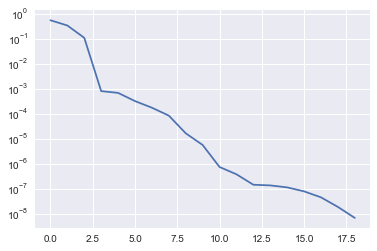

In [46]:
plt.plot(svd.explained_variance_ratio_)
plt.yscale('log')

In [47]:
np.cumsum(svd.explained_variance_ratio_)

array([0.54981534, 0.88880732, 0.99790136, 0.99870937, 0.9993942 ,
       0.99971619, 0.99989143, 0.99997602, 0.99999266, 0.99999832,
       0.99999907, 0.99999945, 0.9999996 , 0.99999973, 0.99999985,
       0.99999993, 0.99999997, 0.99999999, 1.        ])

create a training set, a validation set, and a test set

we return the score on the validation set to the hyper-parameter tuning framework so that it has an idea of generalization, but eventually test the best hyper-parameters on the test set

In [39]:
len(df.ds.unique())

202

In [49]:
dataset = reduct

In [50]:
np.random.seed(94825697)

not_train_months = np.random.choice(ddf.ds.unique(), 40, replace=False)
np.random.shuffle(not_train_months)

train_mask = ~ddf.ds.isin(not_train_months)
val_mask = ddf.ds.isin(not_train_months[:20])
test_mask = ddf.ds.isin(not_train_months[20:])

train_x, train_y = dataset[train_mask], ddf[train_mask].phi_m
val_x, val_y = dataset[val_mask], ddf[val_mask].phi_m
test_x, test_y = dataset[test_mask], ddf[test_mask].phi_m

mu_x, std_x = train_x.mean(), train_x.std()
mu_y, std_y = train_y.mean(), train_y.std()

train_x = (train_x - mu_x) / std_x
train_y = (train_y - mu_y) / std_y

val_x = (val_x - mu_x) / std_x
val_y = (val_y - mu_y) / std_y

test_x = (test_x - mu_x) / std_x
test_y = (test_y - mu_y) / std_y

In [51]:
space = {
    'learning_rate': hp.loguniform('ra_', np.log(1e-4), np.log(1)),
    'max_depth': hp.quniform('md_', 1, 15, 1),
    'min_child_weight': hp.quniform('mcw_', 1, 10, 1),
    'subsample': hp.uniform('ss_', 0.1, 1.0),
    'gamma': hp.uniform('g_', 0, 1),
    'reg_alpha': hp.loguniform('ra_', np.log(1e-20), np.log(1)),
    'reg_lambda': hp.loguniform('ra_', np.log(1e-20), np.log(1)),
    'colsample_bytree': hp.uniform('cbt_', 0.1, 1.0),
    'loss': hp.choice('loss', ['rmse', 'mae',]),
}


def handle_integers(params):
    new_params = {}
    for k, v in params.items():
        if type(v) == float and int(v) == v:
            new_params[k] = int(v)
        else:
            new_params[k] = v

    return new_params


def get_params():
    params = sample(space)
    params = {k: v for k, v in params.items() if v is not 'default'}
    return handle_integers(params)


trees_per_iteration = 15
def try_params(n_iterations, params, get_predictions=False):
    params['n_estimators'] = int(round(n_iterations * trees_per_iteration))
    result = fit_score(params, get_predictions=get_predictions)
    return result


def fit_score(params, save=True, get_predictions=False):
    
    def evaluate(model, xx, yy, std_y):
        pred = model.predict(xx)
        mse = np.mean((pred - yy)**2)
        denorm = mse * std_y**2
        return mse, denorm

    try:
        model = XGB(tree_method='gpu_exact', **params)
        model.fit(train_x, train_y)

        train_mse, train_denorm = evaluate(model, train_x, train_y, std_y)
        
        val_mse = val_denorm = np.nan
        if val_x is not None and val_y is not None:
            val_mse, val_denorm = evaluate(model, val_x, val_y, std_y)
        
        test_mse = test_denorm = np.nan
        if test_x is not None and test_y is not None:
            test_mse, test_denorm = evaluate(model, test_x, test_y, std_y)
        
        test_preds = model.predict(test_x) if get_predictions else None
    finally:
        del(model)  # https://github.com/dmlc/xgboost/issues/3045

    result = {
        'train_mse': train_mse,
        'train_denorm': train_denorm,
        
        'val_mse': val_mse,
        'val_denorm': val_denorm,
        
        'test_mse': test_mse,
        'test_denorm': test_denorm,
        
        'params': params,
        'loss': val_denorm,
        
        'test_preds': test_preds,
    }
    
    if save:
        with open('dev/hyperopt.jsonl', 'a') as f:
            f.write(json.dumps(result))
            f.write('\n')
    
    print(result)

    return result

hyper parameters optimization with hyperband



paper https://arxiv.org/pdf/1603.06560.pdf

code https://github.com/zygmuntz/hyperband

In [52]:
hb = Hyperband(get_params, try_params)
hb_res = hb.run()


*** 81 configurations x 1.0 iterations each

1 | Fri Jun  8 12:11:17 2018 | lowest loss so far: inf (run -1)

{'train_mse': 0.6771058025916465, 'train_denorm': 0.5718895259067656, 'val_mse': 0.6540108916247865, 'val_denorm': 0.5523833606470034, 'test_mse': 0.6770222489027337, 'test_denorm': 0.5718189557250343, 'params': {'colsample_bytree': 0.17450907889568212, 'gamma': 0.9257191568707644, 'learning_rate': 0.05687548203173054, 'loss': 'rmse', 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 2.3889042422560584e-09, 'reg_lambda': 1.3335511937683212e-20, 'subsample': 0.3537868097586552, 'n_estimators': 15}, 'loss': 0.5523833606470034, 'test_preds': None}

6 seconds.

2 | Fri Jun  8 12:11:23 2018 | lowest loss so far: 0.5524 (run 1)

{'train_mse': 1.2125312699328197, 'train_denorm': 1.0241145925125226, 'val_mse': 1.1248576377865114, 'val_denorm': 0.9500646704312684, 'test_mse': 1.2121347947377827, 'test_denorm': 1.0237797260700026, 'params': {'colsample_bytree': 0.7000736856724172, 'ga

{'train_mse': 0.2522414388965483, 'train_denorm': 0.21304534144065693, 'val_mse': 0.2528024409285404, 'val_denorm': 0.21351916869908638, 'test_mse': 0.2750199320567319, 'test_denorm': 0.23228425743338277, 'params': {'colsample_bytree': 0.7227761358781644, 'gamma': 0.07086767863911825, 'learning_rate': 0.09766853809611178, 'loss': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'reg_alpha': 1.2571738307589911e-14, 'reg_lambda': 4.401759402421616e-11, 'subsample': 0.3834454257382728, 'n_estimators': 15}, 'loss': 0.21351916869908638, 'test_preds': None}

10 seconds.

15 | Fri Jun  8 12:13:15 2018 | lowest loss so far: 0.2135 (run 14)

{'train_mse': 1.183085636236392, 'train_denorm': 0.9992445508879787, 'val_mse': 1.0983934562746966, 'val_denorm': 0.927712789587279, 'test_mse': 1.1826866344953224, 'test_denorm': 0.9989075505024217, 'params': {'colsample_bytree': 0.2762573323393174, 'gamma': 0.08383156690163307, 'learning_rate': 0.0026989922720827824, 'loss': 'mae', 'max_depth': 5, 'min_chi

{'train_mse': 1.2168228464181052, 'train_denorm': 1.0277392958191085, 'val_mse': 1.128740666753327, 'val_denorm': 0.9533443109046107, 'test_mse': 1.2163728553775124, 'test_denorm': 1.0273592294219784, 'params': {'colsample_bytree': 0.48767502231102344, 'gamma': 0.07850844125541367, 'learning_rate': 0.0014049568410780242, 'loss': 'rmse', 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 5.0834496745857025e-14, 'reg_lambda': 7.241077510474211e-17, 'subsample': 0.6590809120638588, 'n_estimators': 15}, 'loss': 0.9533443109046107, 'test_preds': None}

6 seconds.

28 | Fri Jun  8 12:15:00 2018 | lowest loss so far: 0.1710 (run 20)

{'train_mse': 1.245871539696609, 'train_denorm': 1.0522740780697835, 'val_mse': 1.1547845048903618, 'val_denorm': 0.9753411660311998, 'test_mse': 1.2454979266068342, 'test_denorm': 1.0519585211627742, 'params': {'colsample_bytree': 0.7806306150680039, 'gamma': 0.35738851535369753, 'learning_rate': 0.00014531437186657864, 'loss': 'rmse', 'max_depth': 8, 'min_chil

{'train_mse': 0.5423668336648414, 'train_denorm': 0.4580878057534554, 'val_mse': 0.5086592192528462, 'val_denorm': 0.42961805767015665, 'test_mse': 0.5509378785170073, 'test_denorm': 0.46532698574315473, 'params': {'colsample_bytree': 0.5183855182766556, 'gamma': 0.3191774856849289, 'learning_rate': 0.04079122142524547, 'loss': 'mae', 'max_depth': 9, 'min_child_weight': 9, 'reg_alpha': 3.036253932775346e-11, 'reg_lambda': 1.7693257147191743e-17, 'subsample': 0.40325906221227703, 'n_estimators': 15}, 'loss': 0.42961805767015665, 'test_preds': None}

10 seconds.

41 | Fri Jun  8 12:16:55 2018 | lowest loss so far: 0.1710 (run 20)

{'train_mse': 0.9078489142839644, 'train_denorm': 0.7667771907988571, 'val_mse': 0.8500033924137961, 'val_denorm': 0.7179203534308412, 'test_mse': 0.9073620180526926, 'test_denorm': 0.7663659539525591, 'params': {'colsample_bytree': 0.3129993560757439, 'gamma': 0.5604681151936222, 'learning_rate': 0.016582133981006622, 'loss': 'rmse', 'max_depth': 5, 'min_child

{'train_mse': 0.3205946865484849, 'train_denorm': 0.27077709657291754, 'val_mse': 0.3050534450375456, 'val_denorm': 0.25765082708050596, 'test_mse': 0.3206439666410988, 'test_denorm': 0.27081871897327764, 'params': {'colsample_bytree': 0.5000357260621546, 'gamma': 0.9215395750122785, 'learning_rate': 0.15355936006283674, 'loss': 'rmse', 'max_depth': 4, 'min_child_weight': 8, 'reg_alpha': 4.8662269441774886e-18, 'reg_lambda': 1.1905034110614301e-20, 'subsample': 0.5862042086366218, 'n_estimators': 15}, 'loss': 0.25765082708050596, 'test_preds': None}

6 seconds.

54 | Fri Jun  8 12:18:47 2018 | lowest loss so far: 0.1710 (run 20)

{'train_mse': 1.2443395572483091, 'train_denorm': 1.050980152197782, 'val_mse': 1.1534664709673548, 'val_denorm': 0.9742279429684637, 'test_mse': 1.2439266026356102, 'test_denorm': 1.0506313670939276, 'params': {'colsample_bytree': 0.15104059283484267, 'gamma': 0.43864366452427683, 'learning_rate': 0.00022033976100691916, 'loss': 'rmse', 'max_depth': 5, 'min_c

{'train_mse': 0.7658241212084343, 'train_denorm': 0.6468217993842666, 'val_mse': 0.7337999835498417, 'val_denorm': 0.6197739305976648, 'test_mse': 0.7653599665146626, 'test_denorm': 0.6464297702408853, 'params': {'colsample_bytree': 0.7447598457855178, 'gamma': 0.5833520677407593, 'learning_rate': 0.04107453539771626, 'loss': 'mae', 'max_depth': 2, 'min_child_weight': 10, 'reg_alpha': 3.163993176715734e-15, 'reg_lambda': 0.0014205775178412026, 'subsample': 0.3683725334160066, 'n_estimators': 15}, 'loss': 0.6197739305976648, 'test_preds': None}

5 seconds.

67 | Fri Jun  8 12:20:21 2018 | lowest loss so far: 0.1710 (run 20)

{'train_mse': 0.13905164487292163, 'train_denorm': 0.11744424425039204, 'val_mse': 0.21885002106807647, 'val_denorm': 0.1848426557773705, 'test_mse': 0.25809602717992675, 'test_denorm': 0.2179901782814362, 'params': {'colsample_bytree': 0.39861339130723983, 'gamma': 0.012358571716772127, 'learning_rate': 0.35365744705426183, 'loss': 'mae', 'max_depth': 11, 'min_chil

{'train_mse': 0.5560385053282214, 'train_denorm': 0.46963502008243774, 'val_mse': 0.5407476365207511, 'val_denorm': 0.45672021758106185, 'test_mse': 0.5566179868485595, 'test_denorm': 0.4701244552795213, 'params': {'colsample_bytree': 0.3646600097607743, 'gamma': 0.11599642885734596, 'learning_rate': 0.09382703282465824, 'loss': 'mae', 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 1.0888617342640146e-19, 'reg_lambda': 0.00014601260912069632, 'subsample': 0.5043549686413834, 'n_estimators': 15}, 'loss': 0.45672021758106185, 'test_preds': None}

5 seconds.

80 | Fri Jun  8 12:22:07 2018 | lowest loss so far: 0.1710 (run 20)

{'train_mse': 1.2281529578731298, 'train_denorm': 1.0373088077678825, 'val_mse': 1.138486524605605, 'val_denorm': 0.9615757483038487, 'test_mse': 1.2280172925609065, 'test_denorm': 1.03719422365002, 'params': {'colsample_bytree': 0.6075514806001746, 'gamma': 0.6524752199210184, 'learning_rate': 0.0007592935181714453, 'loss': 'mae', 'max_depth': 9, 'min_child_we

{'train_mse': 0.07662639108021535, 'train_denorm': 0.06471932495494966, 'val_mse': 0.30172319123739433, 'val_denorm': 0.2548380653826619, 'test_mse': 1.4975806778615128, 'test_denorm': 1.2648698336231319, 'params': {'colsample_bytree': 0.5920910527792408, 'gamma': 0.13250751834458618, 'learning_rate': 0.30678467076045324, 'loss': 'mae', 'max_depth': 14, 'min_child_weight': 7, 'reg_alpha': 1.543805526856739e-11, 'reg_lambda': 9.259645805913328e-12, 'subsample': 0.8150264410361211, 'n_estimators': 45}, 'loss': 0.2548380653826619, 'test_preds': None}

33 seconds.

93 | Fri Jun  8 12:26:38 2018 | lowest loss so far: 0.1552 (run 85)

{'train_mse': 0.23957245039725994, 'train_denorm': 0.20234500214531373, 'val_mse': 0.2249252701971568, 'val_denorm': 0.18997386471236552, 'test_mse': 0.24177458709228916, 'test_denorm': 0.20420494619790022, 'params': {'colsample_bytree': 0.5000357260621546, 'gamma': 0.9215395750122785, 'learning_rate': 0.15355936006283674, 'loss': 'rmse', 'max_depth': 4, 'min_c

{'train_mse': 0.3831544889587151, 'train_denorm': 0.3236156568160415, 'val_mse': 0.3704431284201011, 'val_denorm': 0.3128795297230027, 'test_mse': 0.3848513918732079, 'test_denorm': 0.3250488759666745, 'params': {'colsample_bytree': 0.3646600097607743, 'gamma': 0.11599642885734596, 'learning_rate': 0.09382703282465824, 'loss': 'mae', 'max_depth': 2, 'min_child_weight': 2, 'reg_alpha': 1.0888617342640146e-19, 'reg_lambda': 0.00014601260912069632, 'subsample': 0.5043549686413834, 'n_estimators': 45}, 'loss': 0.3128795297230027, 'test_preds': None}

7 seconds.

106 | Fri Jun  8 12:29:50 2018 | lowest loss so far: 0.1552 (run 85)

{'train_mse': 0.25913067025860415, 'train_denorm': 0.21886404694048886, 'val_mse': 0.2580158644382596, 'val_denorm': 0.21792247212362165, 'test_mse': 0.2820813591302637, 'test_denorm': 0.23824840094810432, 'params': {'colsample_bytree': 0.6229709078339484, 'gamma': 0.16817697243021856, 'learning_rate': 0.03232116906576164, 'loss': 'rmse', 'max_depth': 10, 'min_ch

{'train_mse': 0.09437259122236275, 'train_denorm': 0.07970792193210463, 'val_mse': 0.18336452915422916, 'val_denorm': 0.15487129669360053, 'test_mse': 0.19298809528847427, 'test_denorm': 0.16299944543044573, 'params': {'colsample_bytree': 0.7227761358781644, 'gamma': 0.07086767863911825, 'learning_rate': 0.09766853809611178, 'loss': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'reg_alpha': 1.2571738307589911e-14, 'reg_lambda': 4.401759402421616e-11, 'subsample': 0.3834454257382728, 'n_estimators': 405}, 'loss': 0.15487129669360053, 'test_preds': None}

190 seconds.

119 | Fri Jun  8 12:42:47 2018 | lowest loss so far: 0.1530 (run 109)

{'train_mse': 0.1571706219080954, 'train_denorm': 0.13274769187541602, 'val_mse': 112.90938309819074, 'val_denorm': 95.36425965233087, 'test_mse': 6963.071828572217, 'test_denorm': 5881.071808357366, 'params': {'colsample_bytree': 0.9790095151372091, 'gamma': 0.7858696213543622, 'learning_rate': 0.1081970899066571, 'loss': 'mae', 'max_depth': 7, 'min_

{'train_mse': 1.1264843037430334, 'train_denorm': 0.9514385668284392, 'val_mse': 1.0475258989059515, 'val_denorm': 0.884749602510309, 'test_mse': 1.1260627206845215, 'test_denorm': 0.9510824940632377, 'params': {'colsample_bytree': 0.9415331202774498, 'gamma': 0.08214720092179217, 'learning_rate': 0.0017215343625989448, 'loss': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'reg_alpha': 6.800198980161723e-18, 'reg_lambda': 0.12951397257235742, 'subsample': 0.24226579816752303, 'n_estimators': 45}, 'loss': 0.884749602510309, 'test_preds': None}

13 seconds.

132 | Fri Jun  8 13:01:38 2018 | lowest loss so far: 0.1530 (run 109)

{'train_mse': 0.170019630875431, 'train_denorm': 0.143600078043982, 'val_mse': 84680.79448477678, 'val_denorm': 71522.14502659277, 'test_mse': 120958.3357014811, 'test_denorm': 102162.47592920101, 'params': {'colsample_bytree': 0.9336173671790864, 'gamma': 0.9161484052220625, 'learning_rate': 0.6797797560942291, 'loss': 'rmse', 'max_depth': 13, 'min_child_weight'

{'train_mse': 0.35839641476425493, 'train_denorm': 0.3027047692424293, 'val_mse': 0.3446604864661044, 'val_denorm': 0.2911032831936439, 'test_mse': 0.358186662665567, 'test_denorm': 0.3025276107720433, 'params': {'colsample_bytree': 0.7960207094294981, 'gamma': 0.22670290454938435, 'learning_rate': 0.059591664480690164, 'loss': 'rmse', 'max_depth': 3, 'min_child_weight': 8, 'reg_alpha': 0.920044881351145, 'reg_lambda': 1.157041599909885e-20, 'subsample': 0.18038210190043272, 'n_estimators': 45}, 'loss': 0.2911032831936439, 'test_preds': None}

9 seconds.

145 | Fri Jun  8 13:06:19 2018 | lowest loss so far: 0.1530 (run 109)

{'train_mse': 0.2587229318289285, 'train_denorm': 0.2185196674707684, 'val_mse': 0.3037019062551415, 'val_denorm': 0.2565093055183582, 'test_mse': 0.3292677405834409, 'test_denorm': 0.2781024344170625, 'params': {'colsample_bytree': 0.5823850819267332, 'gamma': 0.8442287499818807, 'learning_rate': 0.024092697030214782, 'loss': 'rmse', 'max_depth': 15, 'min_child_we

{'train_mse': 0.17580938030067683, 'train_denorm': 0.14849015141397745, 'val_mse': 0.19784422172536317, 'val_denorm': 0.16710097259962076, 'test_mse': 0.2118335059074292, 'test_denorm': 0.17891644525992764, 'params': {'colsample_bytree': 0.46794406422936363, 'gamma': 0.5215862496579646, 'learning_rate': 0.4527093735416742, 'loss': 'mae', 'max_depth': 6, 'min_child_weight': 3, 'reg_alpha': 1.6334422814348028e-09, 'reg_lambda': 3.1283683914059626e-11, 'subsample': 0.8548287915408862, 'n_estimators': 135}, 'loss': 0.16710097259962076, 'test_preds': None}

40 seconds.

158 | Fri Jun  8 13:12:47 2018 | lowest loss so far: 0.1530 (run 109)

{'train_mse': 0.10150317176259357, 'train_denorm': 0.08573047307401524, 'val_mse': 0.26548817303114636, 'val_denorm': 0.22423364978929625, 'test_mse': 0.19666029086236828, 'test_denorm': 0.16610101416276643, 'params': {'colsample_bytree': 0.9953516806692896, 'gamma': 0.7674183857909669, 'learning_rate': 0.08093340227480175, 'loss': 'rmse', 'max_depth': 12

{'train_mse': 0.07590968162804916, 'train_denorm': 0.06411398583771953, 'val_mse': 0.1775549514893254, 'val_denorm': 0.14996447621771095, 'test_mse': 0.18797662074058247, 'test_denorm': 0.1587667098781614, 'params': {'colsample_bytree': 0.380330576857573, 'gamma': 0.029303492153040622, 'learning_rate': 0.02642963701460877, 'loss': 'rmse', 'max_depth': 11, 'min_child_weight': 7, 'reg_alpha': 5.788307951957197e-06, 'reg_lambda': 9.14005020567089e-05, 'subsample': 0.8122211560402663, 'n_estimators': 1215}, 'loss': 0.14996447621771095, 'test_preds': None}

747 seconds.

*** 15 configurations x 9.0 iterations each

171 | Fri Jun  8 13:45:41 2018 | lowest loss so far: 0.1495 (run 167)

{'train_mse': 1.17776640019798, 'train_denorm': 0.9947518772695425, 'val_mse': 1.095258863236474, 'val_denorm': 0.9250652846926548, 'test_mse': 1.177161851631958, 'test_denorm': 0.9942412702248433, 'params': {'colsample_bytree': 0.18911680037223827, 'gamma': 0.8060183591457986, 'learning_rate': 0.0004347278781

{'train_mse': 0.30752096774245835, 'train_denorm': 0.25973491849498725, 'val_mse': 0.2917848469935081, 'val_denorm': 0.24644405228134153, 'test_mse': 0.31005530419909716, 'test_denorm': 0.26187544139277946, 'params': {'colsample_bytree': 0.3081627126612892, 'gamma': 0.1293688308575044, 'learning_rate': 0.01249731546519634, 'loss': 'rmse', 'max_depth': 6, 'min_child_weight': 9, 'reg_alpha': 0.0030185771886581158, 'reg_lambda': 0.006838799577466222, 'subsample': 0.8989196346253601, 'n_estimators': 135}, 'loss': 0.24644405228134153, 'test_preds': None}

52 seconds.

184 | Fri Jun  8 14:00:13 2018 | lowest loss so far: 0.1495 (run 167)

{'train_mse': 1.1962580687951256, 'train_denorm': 1.0103701034710753, 'val_mse': 1.1102375552130517, 'val_denorm': 0.9377164198925028, 'test_mse': 1.195861805905595, 'test_denorm': 1.0100354163436562, 'params': {'colsample_bytree': 0.3233666034252184, 'gamma': 0.7426993111031848, 'learning_rate': 0.00023922589416714498, 'loss': 'mae', 'max_depth': 5, 'min_c

{'train_mse': 0.1639059747294568, 'train_denorm': 0.13843643020416757, 'val_mse': 0.2035674118508214, 'val_denorm': 0.17193482939865412, 'test_mse': 0.2165950617003441, 'test_denorm': 0.18293809723007176, 'params': {'colsample_bytree': 0.18016326433347502, 'gamma': 0.7738531040152955, 'learning_rate': 0.6314299233529144, 'loss': 'rmse', 'max_depth': 5, 'min_child_weight': 7, 'reg_alpha': 4.616304804024345e-16, 'reg_lambda': 3.5906553189269874e-09, 'subsample': 0.3567722728400945, 'n_estimators': 405}, 'loss': 0.17193482939865412, 'test_preds': None}

94 seconds.

197 | Fri Jun  8 14:45:46 2018 | lowest loss so far: 0.1495 (run 167)

{'train_mse': 0.1535282593587579, 'train_denorm': 0.12967132037845308, 'val_mse': 0.18871571079927366, 'val_denorm': 0.15939095185282695, 'test_mse': 0.20469098427315527, 'test_denorm': 0.17288380856479185, 'params': {'colsample_bytree': 0.7966617093319741, 'gamma': 0.0372069481596784, 'learning_rate': 0.006817153024726137, 'loss': 'rmse', 'max_depth': 11, 

In [53]:
# bounds for GP optimization
bounds = [dict(zip(['name', 'type', 'domain'], spec)) for spec in [
    ('n_estimators', 'continuous', (1, 3)),
    ('max_depth', 'discrete', (1, 12)),
    ('min_child_weight', 'discrete', (1, 10)),
    ('learning_rate', 'continuous', (-6, 0)),
    ('reg_alpha', 'continuous', (-20, 0)),
    ('reg_lambda', 'continuous', (-20, 0)),
    ('loss', 'discrete', (0, 1)),
    ('colsample_bytree', 'continuous', (0.1, 1.0)),
    ('subsample', 'continuous', (0.1, 1.0)),
    ('gamma', 'continuous', (0, 1)),
]]


keys = [bb['name'] for bb in bounds]
def sanitize_params(pp):
    hyp = dict(zip(keys, pp))
    hyp['n_estimators'] = int(round(10**hyp['n_estimators']))
    hyp['max_depth'] = int(round(hyp['max_depth']))
    hyp['min_child_weight'] = int(round(hyp['min_child_weight']))
    hyp['learning_rate'] = 10**hyp['learning_rate']
    hyp['reg_alpha'] = 10**hyp['reg_alpha']
    hyp['reg_lambda'] = 10**hyp['reg_lambda']
    hyp['loss'] = ['rmse', 'mae'][int(hyp['loss'])]
    hyp['gamma'] = max(0, hyp['gamma'])

    return hyp


class TargetFunction:
    def __init__(self):
        self.best = np.inf
        self.count = 0
    
    def log(self, result):
        self.best = min(self.best, result['val_denorm'])
        self.count += 1
        
        dtime = datetime.datetime.now().isoformat().replace('T', ' ')[:-7]
        print('\n%d | %s | Got %.4f train, %.4f val. | Best val. so far: %.4f' % (
            self.count, dtime, result['train_denorm'],
            result['val_denorm'], self.best
        ))
    
    def __call__(self, params):
        res = np.zeros((params.shape[0], 1))
        for i, pp in enumerate(params):
            hyp = sanitize_params(pp)
            result = fit_score(hyp, save=True)
            res[i] = result['loss']
            self.log(result)
        return res

In [54]:
target = TargetFunction()
bopt = GPyOpt.methods.BayesianOptimization(
    target, bounds,
    model_type='GP_MCMC',
    acquisition_type='EI_MCMC',
)

bopt.run_optimization(max_iter=1000)
bopt.fx_opt, sanitize_params(bopt.x_opt)

{'train_mse': 0.47381350552090085, 'train_denorm': 0.40018706087501715, 'val_mse': 0.4579940890107039, 'val_denorm': 0.38682584232761935, 'test_mse': 0.47815855413827674, 'test_denorm': 0.40385692721543537, 'params': {'n_estimators': 380, 'max_depth': 1, 'min_child_weight': 10, 'learning_rate': 0.022883950187261238, 'reg_alpha': 7.02369981259253e-15, 'reg_lambda': 1.3068339356083681e-05, 'loss': 'mae', 'colsample_bytree': 0.2545402693926547, 'subsample': 0.6130670811424748, 'gamma': 0.287533972319594}, 'loss': 0.38682584232761935, 'test_preds': None}

1 | 2018-06-08 15:40:44 | Got 0.4002 train, 0.3868 val. | Best val. so far: 0.3868
{'train_mse': 0.5566101992162481, 'train_denorm': 0.47011787777666514, 'val_mse': 0.5428216517214397, 'val_denorm': 0.4584719490908279, 'test_mse': 0.5617828773163654, 'test_denorm': 0.4744867672692995, 'params': {'n_estimators': 453, 'max_depth': 1, 'min_child_weight': 10, 'learning_rate': 0.007411770175514668, 'reg_alpha': 8.84793941910474e-06, 'reg_lambd

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


{'train_mse': 1.249906410193979, 'train_denorm': 1.0556819652374967, 'val_mse': 1.1584894526590088, 'val_denorm': 0.978470397555743, 'test_mse': 1.2494932045618545, 'test_denorm': 1.055332968120424, 'params': {'n_estimators': 14, 'max_depth': 12, 'min_child_weight': 10, 'learning_rate': 3.0192824644858843e-06, 'reg_alpha': 1.1761004722859936e-11, 'reg_lambda': 4.0746856884032705e-15, 'loss': 'rmse', 'colsample_bytree': 0.9435887732772853, 'subsample': 0.8734806180315539, 'gamma': 0.14834841957545442}, 'loss': 0.978470397555743, 'test_preds': None}

5 | 2018-06-08 15:49:19 | Got 1.0557 train, 0.9785 val. | Best val. so far: 0.3868
{'train_mse': 1.2495468261828333, 'train_denorm': 1.0553782574138881, 'val_mse': 1.1581645157226, 'val_denorm': 0.9781959529566845, 'test_mse': 1.2491462696537354, 'test_denorm': 1.0550399438406655, 'params': {'n_estimators': 99, 'max_depth': 12, 'min_child_weight': 10, 'learning_rate': 2.055992771502627e-06, 'reg_alpha': 7.282902715862585e-14, 'reg_lambda': 1

{'train_mse': 1.1116344389197361, 'train_denorm': 0.9388962401771688, 'val_mse': 1.042159124395644, 'val_denorm': 0.8802167774797144, 'test_mse': 1.1097765654039595, 'test_denorm': 0.9373270638386032, 'params': {'n_estimators': 1000, 'max_depth': 1, 'min_child_weight': 1, 'learning_rate': 0.0001694257852006192, 'reg_alpha': 4.6824247929676545e-09, 'reg_lambda': 7.2305360947505945e-12, 'loss': 'rmse', 'colsample_bytree': 0.1, 'subsample': 1.0, 'gamma': 1.0}, 'loss': 0.8802167774797144, 'test_preds': None}

19 | 2018-06-08 16:03:01 | Got 0.9389 train, 0.8802 val. | Best val. so far: 0.2322
{'train_mse': 1.249978360854543, 'train_denorm': 1.055742735399266, 'val_mse': 1.1585540632007238, 'val_denorm': 0.9785249681884691, 'test_mse': 1.2495625654378322, 'test_denorm': 1.0553915509273168, 'params': {'n_estimators': 10, 'max_depth': 12, 'min_child_weight': 10, 'learning_rate': 1e-06, 'reg_alpha': 0.35996732577411955, 'reg_lambda': 7.135484698833885e-10, 'loss': 'rmse', 'colsample_bytree': 0.

{'train_mse': 1.2499892770586036, 'train_denorm': 1.0557519553213832, 'val_mse': 1.1585651047920456, 'val_denorm': 0.9785342940137716, 'test_mse': 1.249572716427557, 'test_denorm': 1.0554001245426647, 'params': {'n_estimators': 10, 'max_depth': 1, 'min_child_weight': 1, 'learning_rate': 1e-06, 'reg_alpha': 1.1365262535682866e-19, 'reg_lambda': 1.998354546879137e-11, 'loss': 'rmse', 'colsample_bytree': 0.1, 'subsample': 0.1, 'gamma': 0}, 'loss': 0.9785342940137716, 'test_preds': None}

34 | 2018-06-08 16:38:41 | Got 1.0558 train, 0.9785 val. | Best val. so far: 0.2322
{'train_mse': 0.13465342767801855, 'train_denorm': 0.11372947126099994, 'val_mse': 0.273287009493802, 'val_denorm': 0.23082061577036073, 'test_mse': 0.2942597752835219, 'test_denorm': 0.2485343985182395, 'params': {'n_estimators': 10, 'max_depth': 12, 'min_child_weight': 1, 'learning_rate': 1.0, 'reg_alpha': 1.0, 'reg_lambda': 5.927462261450863e-06, 'loss': 'rmse', 'colsample_bytree': 0.1, 'subsample': 1.0, 'gamma': 0}, 'l

{'train_mse': 1.2272628485185928, 'train_denorm': 1.0365570135655244, 'val_mse': 1.1404671431322988, 'val_denorm': 0.9632485961599705, 'test_mse': 1.226294731869867, 'test_denorm': 1.0357393337152807, 'params': {'n_estimators': 305, 'max_depth': 1, 'min_child_weight': 1, 'learning_rate': 8.014327092437174e-05, 'reg_alpha': 1.4784052289434598e-15, 'reg_lambda': 1.059770100172683e-17, 'loss': 'rmse', 'colsample_bytree': 0.7897012433059144, 'subsample': 0.4939565228357325, 'gamma': 0.5967784484527274}, 'loss': 0.9632485961599705, 'test_preds': None}

49 | 2018-06-08 17:00:08 | Got 1.0366 train, 0.9632 val. | Best val. so far: 0.2295
{'train_mse': 1.2499892770586036, 'train_denorm': 1.0557519553213832, 'val_mse': 1.1585651047920456, 'val_denorm': 0.9785342940137716, 'test_mse': 1.249572716427557, 'test_denorm': 1.0554001245426647, 'params': {'n_estimators': 10, 'max_depth': 1, 'min_child_weight': 10, 'learning_rate': 1e-06, 'reg_alpha': 1.0, 'reg_lambda': 3.2327501734759857e-06, 'loss': 'm

{'train_mse': 1.2479694445034124, 'train_denorm': 1.0540459869513323, 'val_mse': 1.156717277093919, 'val_denorm': 0.976973602461293, 'test_mse': 1.2476028357267193, 'test_denorm': 1.0537363459488571, 'params': {'n_estimators': 1000, 'max_depth': 12, 'min_child_weight': 1, 'learning_rate': 1e-06, 'reg_alpha': 2.9125427145749527e-12, 'reg_lambda': 1.0, 'loss': 'rmse', 'colsample_bytree': 1.0, 'subsample': 0.1, 'gamma': 1.0}, 'loss': 0.976973602461293, 'test_preds': None}

63 | 2018-06-08 17:49:28 | Got 1.0540 train, 0.9770 val. | Best val. so far: 0.2295


KeyboardInterrupt: 

# behavior of model on cyclone

since the soil temperature was not measured in that time, we do not use it

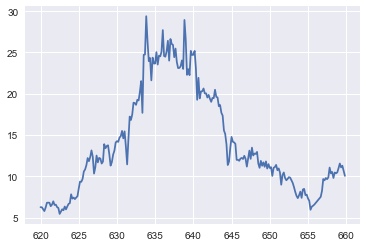

In [4]:
mk = (df.ds == 200210) & (df.z == 40) & (df.tt > 620) & (df.tt < 660)
plt.plot(df[mk].tt, df[mk].wind)

In [5]:
wind_temp_levels = df.pivot_table(
    values=['wind', 'temp'], columns='z', index=['ds', 'tt']
).reset_index()
wind_temp_levels.columns = [
    '%s_%d' % (a, b) if b else a
    for a, b in wind_temp_levels.columns.values
]

ddf = df.merge(wind_temp_levels, on=['ds', 'tt'])
ddf = ddf[(ddf.zL > -2) & (ddf.zL < 1)]

feats = [
    'air_dens', 'wind', 'temp', 'virtual_temp', 'z',
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux',
    'soilheat', 'netrad', 'temp_10', 'temp_20', 'temp_40', 'wind_10',
    'wind_20', 'wind_40'
]

ddf = ddf[feats + ['phi_m', 'ds', 'tt', 'zL', 'lval', 'H', 'LE', 'ustar']].dropna()

In [82]:
found = False
while not found:
    seed = np.random.randint(0, 2**31 - 1)
    np.random.seed(seed)
    test_months = np.random.choice(ddf.ds.unique(), 20, replace=False)
    found = 200210 in test_months
seed

61247877

In [81]:
np.random.seed(61247877)
test_months = np.random.choice(ddf.ds.unique(), 20, replace=False)
assert 200210 in test_months

# split train test
test_mask = ddf.ds.isin(test_months)
train_mask = ~test_mask
train_x, train_y = ddf[train_mask][feats], ddf[train_mask].phi_m
test_x, test_y = ddf[test_mask][feats], ddf[test_mask].phi_m

# normalize
mu_x, std_x = train_x.mean(), train_x.std()
mu_y, std_y = train_y.mean(), train_y.std()
train_x = (train_x - mu_x) / std_x
train_y = (train_y - mu_y) / std_y
val_x = val_y = None
test_x = (test_x - mu_x) / std_x
test_y = (test_y - mu_y) / std_y

# train model
res = fit_score({
    'n_estimators': 1000,
    'max_depth': 12,
    'min_child_weight': 10,
    'learning_rate': 0.04338746572092608,
    'reg_alpha': 1.698719697497604e-07,
    'reg_lambda': 5.955755313103155e-05,
    'loss': 'mae',
    'colsample_bytree': 0.12467084550095234,
    'subsample': 0.4931323091363833,
    'gamma': 0
}, save=False, get_predictions=True)

{'train_mse': 0.07288585376034067, 'train_denorm': 0.06185207229410053, 'val_mse': nan, 'val_denorm': nan, 'test_mse': 0.17562581683055317, 'test_denorm': 0.14903880737999411, 'params': {'n_estimators': 1000, 'max_depth': 12, 'min_child_weight': 10, 'learning_rate': 0.04338746572092608, 'reg_alpha': 1.698719697497604e-07, 'reg_lambda': 5.955755313103155e-05, 'loss': 'mae', 'colsample_bytree': 0.12467084550095234, 'subsample': 0.4931323091363833, 'gamma': 0}, 'loss': nan, 'test_preds': array([1.2720835 , 0.6131188 , 0.82039285, ..., 0.6436394 , 0.9228288 ,
       0.33474898], dtype=float32)}


# cyclone

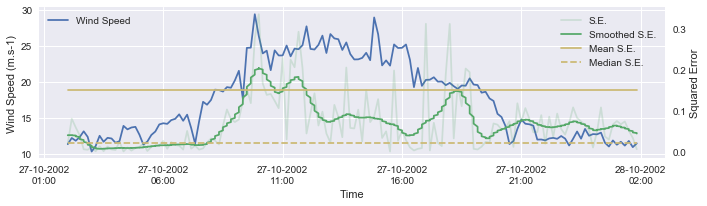

In [82]:
aa = ddf[test_mask].assign(
    sq_err=std_y**2 * (test_y - res['test_preds'])**2
)

cmk = (aa.ds == 200210) & (aa.tt > 626) & (aa.tt < 650)

mean_se, med_se = aa.sq_err.mean(), aa.sq_err.median()

fig, ax = plt.subplots(figsize=(10, 3))
ax2 = ax.twinx()

ax.plot(aa[cmk & (aa.z == 40)].tt, aa[cmk & (aa.z == 40)].wind,
        color='C0', label='Wind Speed')
#ax2.plot(aa[cmk & (aa.z == 40)].tt, aa[cmk & (aa.z == 40)].zL, color='C1')

ax2.plot(aa[cmk].tt.unique(), aa[cmk].groupby('tt').sq_err.mean(),
         color='C1', label='S.E.', alpha=0.2)
ax2.plot(aa[cmk].tt, aa.sq_err.rolling(30, win_type='triang', center=True).mean()[cmk],
         color='C1', label='Smoothed S.E.')
xinterval = aa[cmk].tt.min(), aa[cmk].tt.max()
ax2.plot(xinterval, [mean_se, mean_se], 'C4', label='Mean S.E.')
ax2.plot(xinterval, [med_se, med_se], 'C4--', label='Median S.E.')


ticks, _ = plt.xticks()
datetimes = [
    datetime.datetime(
        day=1, month=10, year=2002
    ) + datetime.timedelta(
        hours=hr
    ) for hr in ticks
]

labels = ['%d-%d-%d\n%02d:%02d' % (
    row.day, row.month, row.year,
    row.hour, row.minute
) for row in datetimes]
plt.xticks(ticks[1:-1], labels[1:-1])

ax.set_ylabel('Wind Speed (m.s-1)')
#ax.set_ylim(0, 32)
ax.set_xlabel('Time')
ax2.set_ylabel('Squared Error')

plt.grid(False)
#plt.legend()
ax2.legend(loc='upper right')
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('manuscript/images/jeanett_error.png')
plt.show()

# density plot

In [6]:
ss = ddf.sample(25000)
kde = stats.gaussian_kde(ss[['zL', 'phi_m']].T, 0.27)

In [7]:
pp2 = kde.logpdf(ss[['zL', 'phi_m']].T)

In [10]:
import bisect
sorted_log_probs = list(sorted(pp2))
point_percentile = [
    bisect.bisect(sorted_log_probs, p) / len(pp2)
    for p in pp2
]

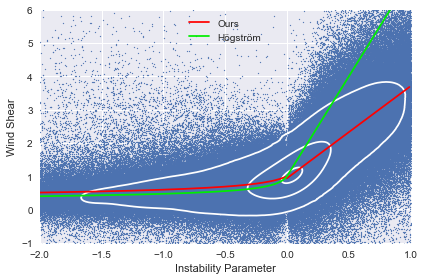

In [159]:
xx = np.arange(-2, 1, 0.01)
our_phim = [
    np.power(1 - 2.64**2 * zL, -0.25) if zL < 0 else (0.94 + 2.77 * zL)
    for zL in xx
]

hogs_phim = [
    np.power(1 - 19.3 * zL, -0.25) if zL < 0 else (1 + 6 * zL)
    for zL in xx
]

levels = [0.1, 0.5, 0.9]

plt.scatter(ddf.zL, ddf.phi_m, s=1, label='')
cs = plt.tricontour(ss.zL, ss.phi_m, point_percentile,
                    levels=levels, colors='#ffffff')
plt.plot(xx, our_phim, color='r', label='Ours')
plt.plot(xx, hogs_phim, color='#00ee00', label='Högström')
plt.legend(loc='upper center')
plt.xlim(-2, 1)
plt.ylim(-1, 6)
plt.xlabel('Instability Parameter')
plt.ylabel('Wind Shear')
plt.tight_layout()
plt.savefig('manuscript/images/most_zoom.png')

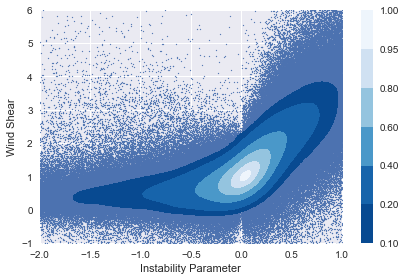

In [122]:
plt.scatter(ddf.zL, ddf.phi_m, s=1)

levels = [
    0.1, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0
]

cm = plt.get_cmap('Blues')
cs = plt.tricontourf(ss.zL, ss.phi_m, point_percentile, levels=levels,
                     colors=[cm(1 - l) for l in levels])
plt.xlim(-2, 1)
plt.ylim(-1, 6)
plt.colorbar()
plt.xlabel('Instability Parameter')
plt.ylabel('Wind Shear')
plt.savefig('manuscript/images/most_density.png')
plt.tight_layout()

In [381]:
pp = kde.logpdf(ps)

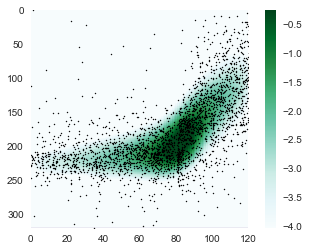

In [487]:
def rescale(data, vmin, vmax, dmin=None, dmax=None):
    dmin = data.min() if dmin is None else dmin
    dmax = data.max() if dmax is None else dmax
    
    data = (data - dmin) / (dmax - dmin)
    return data * (vmax - vmin) + vmin


plt.imshow(np.rot90(pp.T.reshape(len(xs), len(ys))),
           vmin=np.percentile(pp, 75),
           vmax=np.percentile(pp, 99),
           aspect=len(xs) / len(ys),
           cmap='BuGn')
plt.colorbar()


scatter_mask = -np.log(point_percentile) > 9 * np.random.random(size=len(point_percentile))
sdata = ss[scatter_mask]
plt.scatter(rescale(sdata.zL, 0, len(xs), xs.min(), xs.max()),
            rescale(sdata.phi_m, len(ys), 0, ys.min(), ys.max()),
            s=1.2, c='k')


plt.xlim(0, len(xs))
plt.ylim(len(ys), 0)
plt.grid(False)


#xts = plt.xticks()[0].astype(np.int)[1:-1]
#plt.xticks(xts, ['%.1f' % x for x in xs[xts]])

# mse by z/L

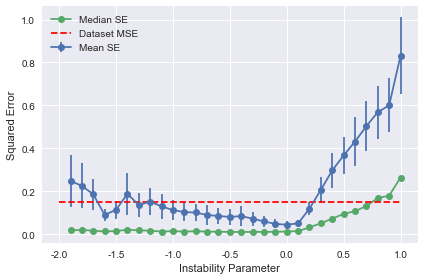

In [180]:
bins = np.arange(-2, 1, 0.1)
err_by_zL = aa.groupby(
    np.digitize(aa.zL, bins)
).sq_err.describe().assign(
    mean_err=lambda df: df['std'] / 10,
    med_err_pos=lambda df: df['75%'] - df['50%'],
    med_err_neg=lambda df: df['50%'] - df['25%'],
)

err_by_zL.plot(
    y='mean', color='C0', rot=0,
    label='Mean SE', yerr='mean_err', marker='o',
)

err_by_zL['50%'].plot(
    color='C1', label='Median SE', marker='o',
    #yerr=err_by_zL[['med_err_neg','med_err_pos']].values.T.reshape(1, 2, -1)
)

mean_se = aa.sq_err.mean()
med_se = aa.sq_err.median()

plt.plot([0, 30], [mean_se, mean_se], 'r--', label='Dataset MSE')
plt.legend(loc='upper left')
ticks = range(0, 31, 5)
_ = plt.xticks(ticks, [t / 10 - 2 for t in ticks])
plt.xlabel('Instability Parameter')
plt.ylabel('Squared Error')
plt.tight_layout()
plt.savefig('manuscript/images/error_by_xi.png')